In [18]:
import random
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTConfig, TrainingArguments, Trainer
import torch
import torchvision.transforms as transforms
import os
from glob import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [19]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator, when = ''):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve ' + when)
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [20]:
IMAGE_SIZE=[128, 128]
EPOCHS = 20
# BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 64

In [21]:
train_df_main = pd.read_csv('train_df.csv')
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)
train_df_main.drop(['No Finding'], axis = 1, inplace = True)
labels = train_df_main.columns[2:-1]
labels

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [22]:
from sklearn.model_selection import train_test_split
train_df, discard = train_test_split(train_df_main, test_size = 0.7, random_state = 47)

train_and_valid_set, test_set = train_test_split(train_df, test_size = 0.2, random_state = 47)
train_set, valid_set = train_test_split(train_and_valid_set, test_size = 0.2, random_state = 47)

In [23]:

def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups)>0 
    return leakage
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True, 
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True, 
        vertical_flip = False, 
        fill_mode = 'reflect')
    
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="FilePath", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = next(raw_train_generator)
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [24]:
train_generator = get_train_generator(df = train_set,
                                      image_dir = None, 
                                      x_col = "FilePath",
                                      y_cols = labels, 
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0], 
                                      target_h = IMAGE_SIZE[1] 
                                      )
valid_generator, test_generator= get_test_and_valid_generator(valid_df = valid_set, 
                                                              test_df = test_set, 
                                                              train_df = train_set,
                                                              image_dir = None, 
                                                              x_col = "FilePath", 
                                                              y_cols = labels,
                                                              batch_size = BATCH_SIZE,
                                                              target_w = IMAGE_SIZE[0], 
                                                              target_h = IMAGE_SIZE[1])

getting train generator...
Found 21476 validated image filenames.
getting train and valid generators...
Found 21476 validated image filenames.
Found 5370 validated image filenames.
Found 6712 validated image filenames.


  0%|          | 0/8 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 8/8 [00:00<00:00, 75.67it/s]


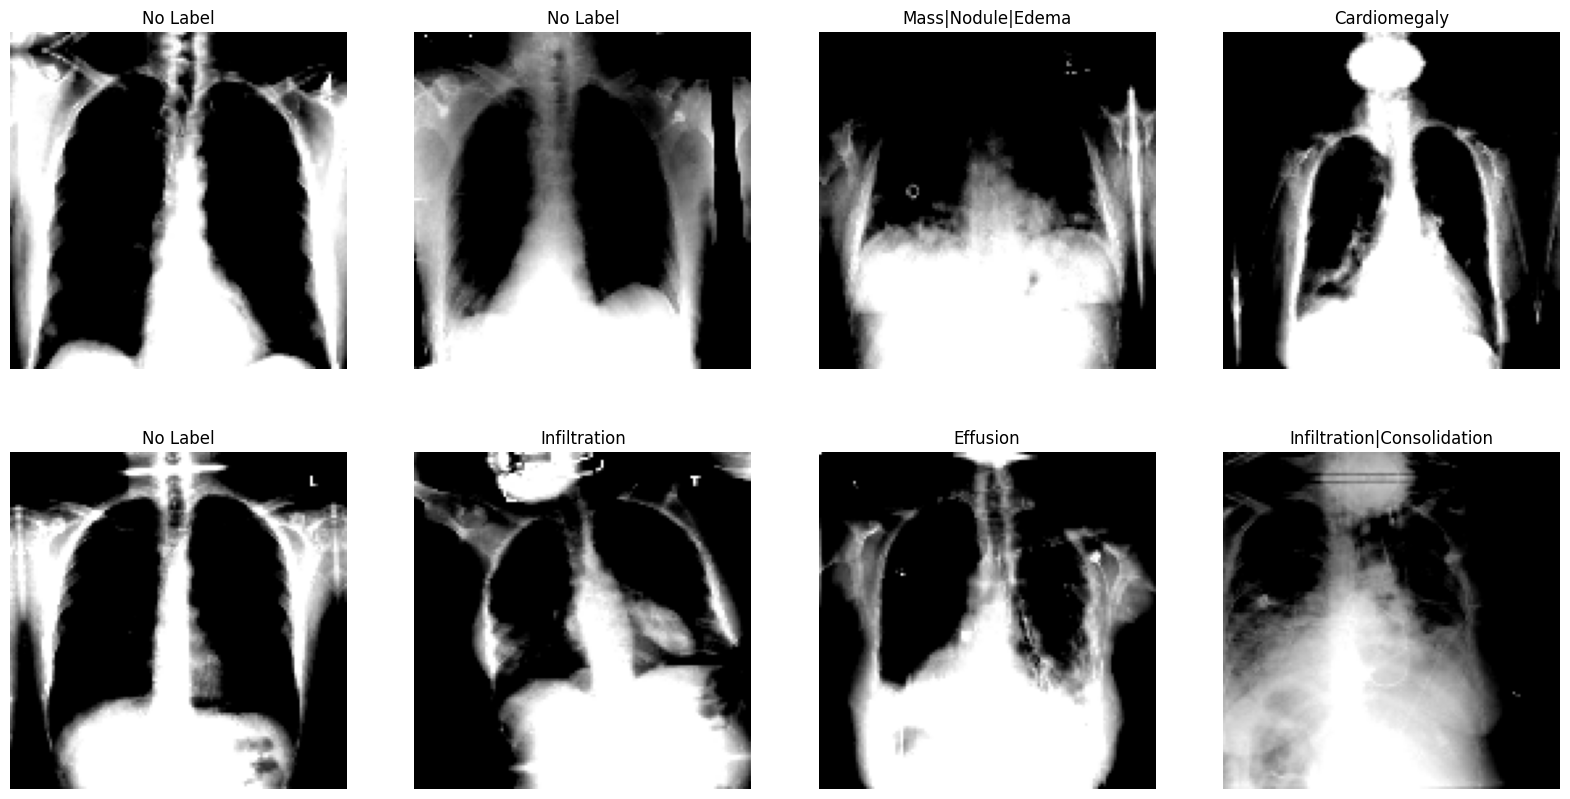

In [25]:

def get_label(y):
    """
    Returns the appended label list of the given set. 
    
    y(list) the one hot vector list containing the label encoding. 
    """
    ret_labels = []
    i = 0
    for idx in y:
        if idx:
            ret_labels.append(labels[i])
        i += 1
    if not ret_labels:
        return 'No Label'
    else:
        return '|'.join(ret_labels)

#get one batch of images from the imageset    
x, y = train_generator.__getitem__(0)



#show a set of images along with the labels appended at the top as title.
fig=plt.figure(figsize=(20, 10))
columns = 4; rows =2 
for i in tqdm(range(1, columns*rows +1)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i-1], cmap = 'gray')
    plt.title(get_label(y[i-1]))
    plt.axis(False)
    fig.add_subplot

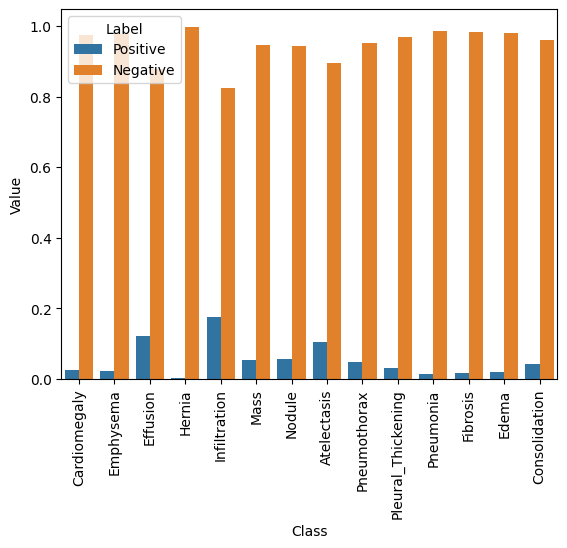

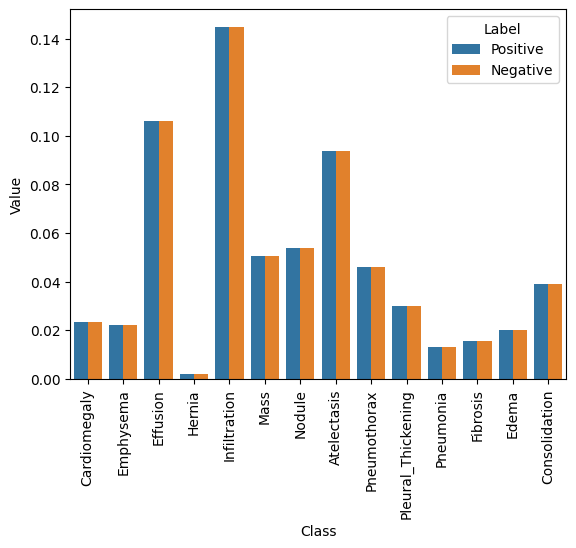

In [26]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequencies for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequencies for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequencies for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0)) / N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies

# Assuming compute_class_freqs and train_generator are defined and labels is a list of class labels
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

# Create the initial DataFrame with positive class frequencies
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})

# Create a DataFrame for negative class frequencies
neg_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])

# Concatenate the two DataFrames
data = pd.concat([data, neg_data], ignore_index=True)

# Plot the data
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()
# Compute class frequencies
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

# Calculate weights and contributions
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

# Create DataFrames for positive and negative contributions
data_pos = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data_neg = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)])

# Concatenate the DataFrames
data = pd.concat([data_pos, data_neg], ignore_index=True)

# Plot the data
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

In [27]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

    return weighted_loss

In [42]:
import pandas as pd
import os
from glob import glob
import numpy as np
from transformers import ViTForImageClassification, TrainingArguments, Trainer, ViTConfig
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torchvision.transforms as transforms

In [43]:
# Load the main dataframe
train_df_main = pd.read_csv('train_df.csv')
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)
train_df_main.drop(['No Finding'], axis=1, inplace=True)

In [44]:
# Function to get a subset of the data with 10 images per label
def create_label_subset(df, labels, num_samples=10):
    subsets = []
    for label in labels:
        label_subset = df[df[label] == 1].sample(n=num_samples, random_state=42)
        subsets.append(label_subset)
    subset_df = pd.concat(subsets)
    return subset_df

# List of labels
labels = train_df_main.columns[2:-1]

# Create subset
subset_df = create_label_subset(train_df_main, labels, num_samples=10)

# Check if the subset was created correctly
#print(subset_df.head())
#print(f"Total images in subset: {len(subset_df)}")
subset_df.to_csv('subset_df.csv', index=False)

In [45]:
import pandas as pd
import os
from glob import glob
import numpy as np
from transformers import ViTForImageClassification, TrainingArguments, Trainer, ViTConfig
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load the main dataframe
train_df_main = pd.read_csv('train_df.csv')
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)
train_df_main.drop(['No Finding'], axis=1, inplace=True)

# Function to get a subset of the data with 10 images per label
def create_label_subset(df, labels, num_samples=10):
    subsets = []
    for label in labels:
        label_subset = df[df[label] == 1].sample(n=num_samples, random_state=42)
        subsets.append(label_subset)
    subset_df = pd.concat(subsets)
    return subset_df

# List of labels
labels = train_df_main.columns[2:-1]

# Create subset
subset_df = create_label_subset(train_df_main, labels, num_samples=10)

# Check if the subset was created correctly
print(subset_df.head())
print(f"Total images in subset: {len(subset_df)}")

# Save to a new CSV (optional)
subset_df.to_csv('subset_df.csv', index=False)

# Define custom dataset for ViT
class CustomImageDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        self.image_paths = df['FilePath'].values
        self.label_values = df[labels].values
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label_values[idx], dtype=torch.float32)
        return {"pixel_values": image, "labels": label}

# Custom transform function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and dataloaders
train_dataset = CustomImageDataset(subset_df, labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Initialize the model from scratch
config = ViTConfig(
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=12,
    image_size=224,
    patch_size=16,
    num_labels=len(labels)
)
model = ViTForImageClassification(config)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=2,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = torch.nn.BCEWithLogitsLoss()(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./trained_model')


  3%|▎         | 10/350 [00:21<12:38,  2.23s/it]

{'loss': 0.5494, 'grad_norm': 2.3634917736053467, 'learning_rate': 5e-05, 'epoch': 0.14}


  6%|▌         | 20/350 [00:43<11:58,  2.18s/it]

{'loss': 0.5235, 'grad_norm': 2.7325687408447266, 'learning_rate': 4.8529411764705885e-05, 'epoch': 0.29}


  9%|▊         | 30/350 [01:07<11:54,  2.23s/it]

{'loss': 0.5001, 'grad_norm': 2.691471576690674, 'learning_rate': 4.705882352941177e-05, 'epoch': 0.43}


 11%|█▏        | 40/350 [01:29<11:17,  2.18s/it]

{'loss': 0.3985, 'grad_norm': 2.030019998550415, 'learning_rate': 4.558823529411765e-05, 'epoch': 0.57}


 14%|█▍        | 50/350 [01:50<10:41,  2.14s/it]

{'loss': 0.4044, 'grad_norm': 2.7014894485473633, 'learning_rate': 4.411764705882353e-05, 'epoch': 0.71}


 17%|█▋        | 60/350 [02:12<10:25,  2.16s/it]

{'loss': 0.4605, 'grad_norm': 1.8252644538879395, 'learning_rate': 4.2647058823529415e-05, 'epoch': 0.86}


 20%|██        | 70/350 [02:34<09:59,  2.14s/it]

{'loss': 0.3991, 'grad_norm': 1.5948736667633057, 'learning_rate': 4.11764705882353e-05, 'epoch': 1.0}


 23%|██▎       | 80/350 [02:57<09:40,  2.15s/it]

{'loss': 0.4925, 'grad_norm': 2.2159805297851562, 'learning_rate': 3.970588235294117e-05, 'epoch': 1.14}


 26%|██▌       | 90/350 [03:18<08:59,  2.08s/it]

{'loss': 0.4094, 'grad_norm': 2.179600954055786, 'learning_rate': 3.8235294117647055e-05, 'epoch': 1.29}


 29%|██▊       | 100/350 [03:39<08:47,  2.11s/it]

{'loss': 0.4209, 'grad_norm': 1.6989737749099731, 'learning_rate': 3.6764705882352945e-05, 'epoch': 1.43}


 31%|███▏      | 110/350 [04:00<08:05,  2.02s/it]

{'loss': 0.3963, 'grad_norm': 1.7991551160812378, 'learning_rate': 3.529411764705883e-05, 'epoch': 1.57}


 34%|███▍      | 120/350 [04:21<07:57,  2.08s/it]

{'loss': 0.3823, 'grad_norm': 1.8187613487243652, 'learning_rate': 3.382352941176471e-05, 'epoch': 1.71}


 37%|███▋      | 130/350 [04:42<07:39,  2.09s/it]

{'loss': 0.4345, 'grad_norm': 1.702942132949829, 'learning_rate': 3.235294117647059e-05, 'epoch': 1.86}


 40%|████      | 140/350 [05:03<07:12,  2.06s/it]

{'loss': 0.4058, 'grad_norm': 1.5605497360229492, 'learning_rate': 3.0882352941176475e-05, 'epoch': 2.0}


 43%|████▎     | 150/350 [05:25<07:14,  2.17s/it]

{'loss': 0.3786, 'grad_norm': 1.2753880023956299, 'learning_rate': 2.9411764705882354e-05, 'epoch': 2.14}


 46%|████▌     | 160/350 [05:46<06:40,  2.11s/it]

{'loss': 0.3921, 'grad_norm': 1.8182542324066162, 'learning_rate': 2.7941176470588236e-05, 'epoch': 2.29}


 49%|████▊     | 170/350 [06:07<06:13,  2.08s/it]

{'loss': 0.4353, 'grad_norm': 2.198906660079956, 'learning_rate': 2.647058823529412e-05, 'epoch': 2.43}


 51%|█████▏    | 180/350 [06:28<06:03,  2.14s/it]

{'loss': 0.4178, 'grad_norm': 1.6375315189361572, 'learning_rate': 2.5e-05, 'epoch': 2.57}


 54%|█████▍    | 190/350 [06:50<05:43,  2.14s/it]

{'loss': 0.3912, 'grad_norm': 2.2500898838043213, 'learning_rate': 2.3529411764705884e-05, 'epoch': 2.71}


 57%|█████▋    | 200/350 [07:12<05:14,  2.10s/it]

{'loss': 0.4136, 'grad_norm': 2.2318315505981445, 'learning_rate': 2.2058823529411766e-05, 'epoch': 2.86}


 60%|██████    | 210/350 [07:33<04:49,  2.07s/it]

{'loss': 0.4447, 'grad_norm': 2.290634870529175, 'learning_rate': 2.058823529411765e-05, 'epoch': 3.0}


 63%|██████▎   | 220/350 [07:54<04:29,  2.07s/it]

{'loss': 0.3837, 'grad_norm': 1.4849337339401245, 'learning_rate': 1.9117647058823528e-05, 'epoch': 3.14}


 66%|██████▌   | 230/350 [08:14<04:04,  2.04s/it]

{'loss': 0.4378, 'grad_norm': 1.7684850692749023, 'learning_rate': 1.7647058823529414e-05, 'epoch': 3.29}


 69%|██████▊   | 240/350 [08:35<03:56,  2.15s/it]

{'loss': 0.4104, 'grad_norm': 1.7934263944625854, 'learning_rate': 1.6176470588235296e-05, 'epoch': 3.43}


 71%|███████▏  | 250/350 [08:57<03:45,  2.26s/it]

{'loss': 0.3938, 'grad_norm': 1.5208531618118286, 'learning_rate': 1.4705882352941177e-05, 'epoch': 3.57}


 74%|███████▍  | 260/350 [09:21<03:39,  2.43s/it]

{'loss': 0.4009, 'grad_norm': 1.683473825454712, 'learning_rate': 1.323529411764706e-05, 'epoch': 3.71}


 77%|███████▋  | 270/350 [09:45<03:24,  2.56s/it]

{'loss': 0.3858, 'grad_norm': 2.4315218925476074, 'learning_rate': 1.1764705882352942e-05, 'epoch': 3.86}


 80%|████████  | 280/350 [10:07<02:31,  2.17s/it]

{'loss': 0.413, 'grad_norm': 1.769647479057312, 'learning_rate': 1.0294117647058824e-05, 'epoch': 4.0}


 83%|████████▎ | 290/350 [10:30<02:08,  2.14s/it]

{'loss': 0.4109, 'grad_norm': 2.249980926513672, 'learning_rate': 8.823529411764707e-06, 'epoch': 4.14}


 86%|████████▌ | 300/350 [10:53<01:50,  2.21s/it]

{'loss': 0.3928, 'grad_norm': 1.5994619131088257, 'learning_rate': 7.3529411764705884e-06, 'epoch': 4.29}


 89%|████████▊ | 310/350 [11:13<01:21,  2.03s/it]

{'loss': 0.3766, 'grad_norm': 1.3412541151046753, 'learning_rate': 5.882352941176471e-06, 'epoch': 4.43}


 91%|█████████▏| 320/350 [11:35<01:02,  2.08s/it]

{'loss': 0.4093, 'grad_norm': 1.8920416831970215, 'learning_rate': 4.411764705882353e-06, 'epoch': 4.57}


 94%|█████████▍| 330/350 [11:56<00:41,  2.06s/it]

{'loss': 0.4075, 'grad_norm': 2.277642250061035, 'learning_rate': 2.9411764705882355e-06, 'epoch': 4.71}


 97%|█████████▋| 340/350 [12:16<00:20,  2.06s/it]

{'loss': 0.3973, 'grad_norm': 2.427999973297119, 'learning_rate': 1.4705882352941177e-06, 'epoch': 4.86}


100%|██████████| 350/350 [12:41<00:00,  2.17s/it]


{'loss': 0.4035, 'grad_norm': 1.7307379245758057, 'learning_rate': 0.0, 'epoch': 5.0}
{'train_runtime': 761.2574, 'train_samples_per_second': 0.92, 'train_steps_per_second': 0.46, 'train_loss': 0.41924919264657157, 'epoch': 5.0}


In [48]:
def create_label_subset(df, labels, num_samples=100):
    subsets = []
    for label in labels:
        label_subset = df[df[label] == 1].sample(n=num_samples, random_state=42)
        subsets.append(label_subset)
    subset_df = pd.concat(subsets)
    return subset_df

# List of labels
labels = train_df_main.columns[2:-1]

# Create subset
subset_df = create_label_subset(train_df_main, labels, num_samples=10)

# Check if the subset was created correctly
print(subset_df.head())
print(f"Total images in subset: {len(subset_df)}")

            Image Index  Patient ID  Cardiomegaly  Emphysema  Effusion  \
27158  00007094_000.png        7094             1          0         0   
76917  00018949_013.png       18949             1          0         0   
28034  00007326_000.png        7326             1          0         0   
29462  00007688_000.png        7688             1          0         0   
61409  00015202_000.png       15202             1          0         0   

       Hernia  Infiltration  Mass  Nodule  Atelectasis  Pneumothorax  \
27158       0             0     0       0            0             0   
76917       0             1     0       0            0             0   
28034       0             0     0       0            0             0   
29462       0             0     0       0            0             0   
61409       0             0     0       0            0             0   

       Pleural_Thickening  Pneumonia  Fibrosis  Edema  Consolidation  \
27158                   0          0         0    

In [49]:
import pandas as pd
import os
from glob import glob
import numpy as np
from transformers import ViTForImageClassification, TrainingArguments, Trainer, ViTConfig
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Load the main dataframe
train_df_main = pd.read_csv('train_df.csv')
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)
train_df_main.drop(['No Finding'], axis=1, inplace=True)

def create_label_subset(df, labels, num_samples=50):
    subsets = []
    for label in labels:
        label_subset = df[df[label] == 1].sample(n=num_samples, random_state=42)
        subsets.append(label_subset)
    subset_df = pd.concat(subsets)
    return subset_df

# List of labels
labels = train_df_main.columns[2:-1]

# Create subset
subset_df = create_label_subset(train_df_main, labels, num_samples=50)

# Check if the subset was created correctly
print(subset_df.head())
print(f"Total images in subset: {len(subset_df)}")
a
# Save to a new CSV (optional)
subset_df.to_csv('subset_df.csv', index=False)

# Split the subset into train, validation, and test sets
train_df, test_df = train_test_split(subset_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Define custom dataset for ViT
class CustomImageDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        self.image_paths = df['FilePath'].values
        self.label_values = df[labels].values
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label_values[idx], dtype=torch.float32)
        return {"pixel_values": image, "labels": label}

# Custom transform function with data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transform for validation and test datasets
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
train_dataset = CustomImageDataset(train_df, labels, transform=train_transform)
val_dataset = CustomImageDataset(val_df, labels, transform=val_test_transform)
test_dataset = CustomImageDataset(test_df, labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize the model from scratch
config = ViTConfig(
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=12,
    image_size=224,
    patch_size=16,
    num_labels=len(labels)
)
model = ViTForImageClassification(config)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=4,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = torch.nn.BCEWithLogitsLoss()(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./trained_model')

# Evaluation on test set
def evaluate_model(trainer, dataset):
    predictions, labels = [], []
    for batch in DataLoader(dataset, batch_size=4):
        inputs = {"pixel_values": batch["pixel_values"].to(trainer.args.device)}
        outputs = trainer.model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        predictions.append(logits)
        labels.append(batch["labels"].numpy())
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    predictions = (predictions > 0.5).astype(int)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return acc, f1

# Calculate accuracy and F1 score
accuracy, f1 = evaluate_model(trainer, test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")


            Image Index  Patient ID  Cardiomegaly  Emphysema  Effusion  \
27158  00007094_000.png        7094             1          0         0   
76917  00018949_013.png       18949             1          0         0   
28034  00007326_000.png        7326             1          0         0   
29462  00007688_000.png        7688             1          0         0   
61409  00015202_000.png       15202             1          0         0   

       Hernia  Infiltration  Mass  Nodule  Atelectasis  Pneumothorax  \
27158       0             0     0       0            0             0   
76917       0             1     0       0            0             0   
28034       0             0     0       0            0             0   
29462       0             0     0       0            0             0   
61409       0             0     0       0            0             0   

       Pleural_Thickening  Pneumonia  Fibrosis  Edema  Consolidation  \
27158                   0          0         0    

c:\Users\sasha\anaconda3\envs\cv\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  2%|▏         | 10/525 [00:35<31:19,  3.65s/it]

{'loss': 0.508, 'grad_norm': 2.701911449432373, 'learning_rate': 5e-05, 'epoch': 0.1}


  4%|▍         | 20/525 [01:12<29:58,  3.56s/it]

{'loss': 0.4562, 'grad_norm': 1.9771713018417358, 'learning_rate': 4.902912621359224e-05, 'epoch': 0.19}


  6%|▌         | 30/525 [01:48<29:45,  3.61s/it]

{'loss': 0.4335, 'grad_norm': 1.6660269498825073, 'learning_rate': 4.805825242718447e-05, 'epoch': 0.29}


  8%|▊         | 40/525 [02:24<28:49,  3.57s/it]

{'loss': 0.3967, 'grad_norm': 1.9603954553604126, 'learning_rate': 4.7087378640776703e-05, 'epoch': 0.38}


 10%|▉         | 50/525 [03:02<30:47,  3.89s/it]

{'loss': 0.3767, 'grad_norm': 1.3840526342391968, 'learning_rate': 4.611650485436894e-05, 'epoch': 0.48}


 11%|█▏        | 60/525 [03:43<31:40,  4.09s/it]

{'loss': 0.3647, 'grad_norm': 0.9794645309448242, 'learning_rate': 4.514563106796117e-05, 'epoch': 0.57}


 13%|█▎        | 70/525 [04:21<26:37,  3.51s/it]

{'loss': 0.444, 'grad_norm': 1.6461033821105957, 'learning_rate': 4.4174757281553404e-05, 'epoch': 0.67}


 15%|█▌        | 80/525 [04:59<28:49,  3.89s/it]

{'loss': 0.4186, 'grad_norm': 1.328853726387024, 'learning_rate': 4.3203883495145634e-05, 'epoch': 0.76}


 17%|█▋        | 90/525 [05:35<25:47,  3.56s/it]

{'loss': 0.4212, 'grad_norm': 2.1371686458587646, 'learning_rate': 4.223300970873786e-05, 'epoch': 0.86}


 19%|█▉        | 100/525 [06:10<24:29,  3.46s/it]

{'loss': 0.4409, 'grad_norm': 1.2029484510421753, 'learning_rate': 4.12621359223301e-05, 'epoch': 0.95}


                                                 
 20%|██        | 105/525 [07:11<25:20,  3.62s/it]

{'eval_loss': 0.3882383108139038, 'eval_runtime': 42.8658, 'eval_samples_per_second': 3.266, 'eval_steps_per_second': 0.42, 'epoch': 1.0}


 21%|██        | 110/525 [07:28<45:15,  6.54s/it]  

{'loss': 0.437, 'grad_norm': 1.2021915912628174, 'learning_rate': 4.029126213592233e-05, 'epoch': 1.05}


 23%|██▎       | 120/525 [08:02<23:33,  3.49s/it]

{'loss': 0.4279, 'grad_norm': 1.514214038848877, 'learning_rate': 3.9320388349514564e-05, 'epoch': 1.14}


 25%|██▍       | 130/525 [08:37<22:41,  3.45s/it]

{'loss': 0.4258, 'grad_norm': 1.3555866479873657, 'learning_rate': 3.83495145631068e-05, 'epoch': 1.24}


 27%|██▋       | 140/525 [09:12<23:18,  3.63s/it]

{'loss': 0.4015, 'grad_norm': 1.4456816911697388, 'learning_rate': 3.737864077669903e-05, 'epoch': 1.33}


 29%|██▊       | 150/525 [09:47<21:40,  3.47s/it]

{'loss': 0.3847, 'grad_norm': 0.9766743183135986, 'learning_rate': 3.6407766990291265e-05, 'epoch': 1.43}


 30%|███       | 160/525 [10:21<20:23,  3.35s/it]

{'loss': 0.4251, 'grad_norm': 1.0456781387329102, 'learning_rate': 3.54368932038835e-05, 'epoch': 1.52}


 32%|███▏      | 170/525 [10:55<20:02,  3.39s/it]

{'loss': 0.405, 'grad_norm': 1.7448294162750244, 'learning_rate': 3.446601941747573e-05, 'epoch': 1.62}


 34%|███▍      | 180/525 [11:30<19:55,  3.47s/it]

{'loss': 0.3907, 'grad_norm': 1.390286922454834, 'learning_rate': 3.3495145631067966e-05, 'epoch': 1.71}


 36%|███▌      | 190/525 [12:05<20:10,  3.61s/it]

{'loss': 0.3929, 'grad_norm': 1.5581421852111816, 'learning_rate': 3.2524271844660195e-05, 'epoch': 1.81}


 38%|███▊      | 200/525 [12:39<18:36,  3.44s/it]

{'loss': 0.4309, 'grad_norm': 1.7421656847000122, 'learning_rate': 3.155339805825243e-05, 'epoch': 1.9}


 40%|████      | 210/525 [13:14<17:21,  3.31s/it]

{'loss': 0.3973, 'grad_norm': 1.3664100170135498, 'learning_rate': 3.058252427184466e-05, 'epoch': 2.0}


                                                 
 40%|████      | 210/525 [13:50<17:21,  3.31s/it]

{'eval_loss': 0.39059218764305115, 'eval_runtime': 36.4925, 'eval_samples_per_second': 3.836, 'eval_steps_per_second': 0.493, 'epoch': 2.0}


 42%|████▏     | 220/525 [14:25<19:32,  3.84s/it]  

{'loss': 0.421, 'grad_norm': 1.1848478317260742, 'learning_rate': 2.9611650485436892e-05, 'epoch': 2.1}


 44%|████▍     | 230/525 [14:58<16:25,  3.34s/it]

{'loss': 0.4408, 'grad_norm': 1.196885347366333, 'learning_rate': 2.8640776699029125e-05, 'epoch': 2.19}


 46%|████▌     | 240/525 [15:34<16:34,  3.49s/it]

{'loss': 0.4046, 'grad_norm': 1.3350986242294312, 'learning_rate': 2.766990291262136e-05, 'epoch': 2.29}


 48%|████▊     | 250/525 [16:09<16:35,  3.62s/it]

{'loss': 0.4085, 'grad_norm': 0.8826286196708679, 'learning_rate': 2.6699029126213593e-05, 'epoch': 2.38}


 50%|████▉     | 260/525 [16:46<15:32,  3.52s/it]

{'loss': 0.3803, 'grad_norm': 1.2029739618301392, 'learning_rate': 2.5728155339805826e-05, 'epoch': 2.48}


 51%|█████▏    | 270/525 [17:21<14:51,  3.50s/it]

{'loss': 0.4136, 'grad_norm': 1.1277674436569214, 'learning_rate': 2.475728155339806e-05, 'epoch': 2.57}


 53%|█████▎    | 280/525 [17:56<14:22,  3.52s/it]

{'loss': 0.4069, 'grad_norm': 1.144269585609436, 'learning_rate': 2.3786407766990294e-05, 'epoch': 2.67}


 55%|█████▌    | 290/525 [18:30<12:56,  3.31s/it]

{'loss': 0.3767, 'grad_norm': 1.5616153478622437, 'learning_rate': 2.2815533980582527e-05, 'epoch': 2.76}


 57%|█████▋    | 300/525 [19:03<12:23,  3.31s/it]

{'loss': 0.4025, 'grad_norm': 1.3869705200195312, 'learning_rate': 2.1844660194174756e-05, 'epoch': 2.86}


 59%|█████▉    | 310/525 [19:38<12:04,  3.37s/it]

{'loss': 0.4146, 'grad_norm': 1.2697025537490845, 'learning_rate': 2.0873786407766992e-05, 'epoch': 2.95}


                                                 
 60%|██████    | 315/525 [20:30<11:47,  3.37s/it]

{'eval_loss': 0.381216436624527, 'eval_runtime': 35.2028, 'eval_samples_per_second': 3.977, 'eval_steps_per_second': 0.511, 'epoch': 3.0}


 61%|██████    | 320/525 [20:47<20:11,  5.91s/it]

{'loss': 0.3922, 'grad_norm': 1.586212396621704, 'learning_rate': 1.9902912621359225e-05, 'epoch': 3.05}


 63%|██████▎   | 330/525 [21:21<11:04,  3.41s/it]

{'loss': 0.4328, 'grad_norm': 1.5838547945022583, 'learning_rate': 1.8932038834951457e-05, 'epoch': 3.14}


 65%|██████▍   | 340/525 [21:55<10:09,  3.29s/it]

{'loss': 0.3966, 'grad_norm': 1.2156039476394653, 'learning_rate': 1.796116504854369e-05, 'epoch': 3.24}


 67%|██████▋   | 350/525 [22:28<09:37,  3.30s/it]

{'loss': 0.4045, 'grad_norm': 1.3320976495742798, 'learning_rate': 1.6990291262135926e-05, 'epoch': 3.33}


 69%|██████▊   | 360/525 [23:01<08:57,  3.26s/it]

{'loss': 0.4108, 'grad_norm': 1.1731611490249634, 'learning_rate': 1.6019417475728158e-05, 'epoch': 3.43}


 70%|███████   | 370/525 [23:36<08:44,  3.38s/it]

{'loss': 0.4321, 'grad_norm': 1.7750853300094604, 'learning_rate': 1.5048543689320387e-05, 'epoch': 3.52}


 72%|███████▏  | 380/525 [24:10<08:11,  3.39s/it]

{'loss': 0.3995, 'grad_norm': 1.5151346921920776, 'learning_rate': 1.4077669902912621e-05, 'epoch': 3.62}


 74%|███████▍  | 390/525 [24:44<07:32,  3.35s/it]

{'loss': 0.3735, 'grad_norm': 0.8463892340660095, 'learning_rate': 1.3106796116504854e-05, 'epoch': 3.71}


 76%|███████▌  | 400/525 [25:17<06:55,  3.33s/it]

{'loss': 0.3937, 'grad_norm': 1.4092196226119995, 'learning_rate': 1.2135922330097088e-05, 'epoch': 3.81}


 78%|███████▊  | 410/525 [25:50<06:18,  3.29s/it]

{'loss': 0.3828, 'grad_norm': 1.4874852895736694, 'learning_rate': 1.116504854368932e-05, 'epoch': 3.9}


 80%|████████  | 420/525 [26:23<05:45,  3.29s/it]

{'loss': 0.4139, 'grad_norm': 1.4080860614776611, 'learning_rate': 1.0194174757281553e-05, 'epoch': 4.0}


                                                 
 80%|████████  | 420/525 [26:58<05:45,  3.29s/it]

{'eval_loss': 0.3813706636428833, 'eval_runtime': 35.0474, 'eval_samples_per_second': 3.995, 'eval_steps_per_second': 0.514, 'epoch': 4.0}


 82%|████████▏ | 430/525 [27:32<05:55,  3.75s/it]

{'loss': 0.3861, 'grad_norm': 1.0104212760925293, 'learning_rate': 9.223300970873788e-06, 'epoch': 4.1}


 84%|████████▍ | 440/525 [28:06<04:42,  3.32s/it]

{'loss': 0.371, 'grad_norm': 1.0198328495025635, 'learning_rate': 8.25242718446602e-06, 'epoch': 4.19}


 86%|████████▌ | 450/525 [28:40<04:10,  3.34s/it]

{'loss': 0.3601, 'grad_norm': 1.1214401721954346, 'learning_rate': 7.281553398058253e-06, 'epoch': 4.29}


 88%|████████▊ | 460/525 [29:15<04:03,  3.75s/it]

{'loss': 0.3775, 'grad_norm': 0.8373161554336548, 'learning_rate': 6.310679611650486e-06, 'epoch': 4.38}


 90%|████████▉ | 470/525 [29:49<03:05,  3.37s/it]

{'loss': 0.4092, 'grad_norm': 1.140433669090271, 'learning_rate': 5.3398058252427185e-06, 'epoch': 4.48}


 91%|█████████▏| 480/525 [30:24<02:34,  3.44s/it]

{'loss': 0.3738, 'grad_norm': 0.9520385265350342, 'learning_rate': 4.368932038834952e-06, 'epoch': 4.57}


 93%|█████████▎| 490/525 [30:57<01:55,  3.29s/it]

{'loss': 0.4483, 'grad_norm': 1.310912013053894, 'learning_rate': 3.3980582524271844e-06, 'epoch': 4.67}


 95%|█████████▌| 500/525 [31:33<01:28,  3.56s/it]

{'loss': 0.4321, 'grad_norm': 1.274601697921753, 'learning_rate': 2.4271844660194174e-06, 'epoch': 4.76}


 97%|█████████▋| 510/525 [32:17<00:53,  3.55s/it]

{'loss': 0.3843, 'grad_norm': 1.327110767364502, 'learning_rate': 1.4563106796116506e-06, 'epoch': 4.86}


 99%|█████████▉| 520/525 [32:52<00:16,  3.38s/it]

{'loss': 0.4329, 'grad_norm': 1.125193476676941, 'learning_rate': 4.854368932038835e-07, 'epoch': 4.95}


                                                 
100%|██████████| 525/525 [33:45<00:00,  3.86s/it]


{'eval_loss': 0.38076281547546387, 'eval_runtime': 35.6611, 'eval_samples_per_second': 3.926, 'eval_steps_per_second': 0.505, 'epoch': 5.0}
{'train_runtime': 2025.8795, 'train_samples_per_second': 1.037, 'train_steps_per_second': 0.259, 'train_loss': 0.4087945942651658, 'epoch': 5.0}
Test Accuracy: 0.0000
Test F1 Score: 0.0000
